In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import scipy
!pip install colorama
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import *
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
from keras.losses import *
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imagesize = [224,224]
body_train = "/content/drive/MyDrive/Dataset/body/training"
body_val = "/content/drive/MyDrive/Dataset/body/validation"
level_train = "/content/drive/MyDrive/Dataset/level/training"
level_val = "/content/drive/MyDrive/Dataset/level/validation"

Data pre processing

In [ ]:
trainDatagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.1,
                                       zoom_range = 0.1,
                                       horizontal_flip = True)

valDatagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#For body image processing
body_train_set = trainDatagen.flow_from_directory(body_train,
                                                       target_size = (200,200),
                                                       batch_size = 32,
                                                       class_mode = 'categorical')

body_val_set = valDatagen.flow_from_directory(body_val,
                                                   target_size = (200,200),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')

Found 989 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
#For level image processing
level_train_set = trainDatagen.flow_from_directory(level_train,
                                                       target_size = (200,200),
                                                       batch_size = 32,
                                                       class_mode = 'categorical')

level_val_set = valDatagen.flow_from_directory(level_val,
                                                   target_size = (200,200),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
def plot_images(x):
  images, labels = next(x)
  fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
  axes = axes.flatten()
  for i in range(len(images)):
    img = images[i]
    label = labels[i]
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

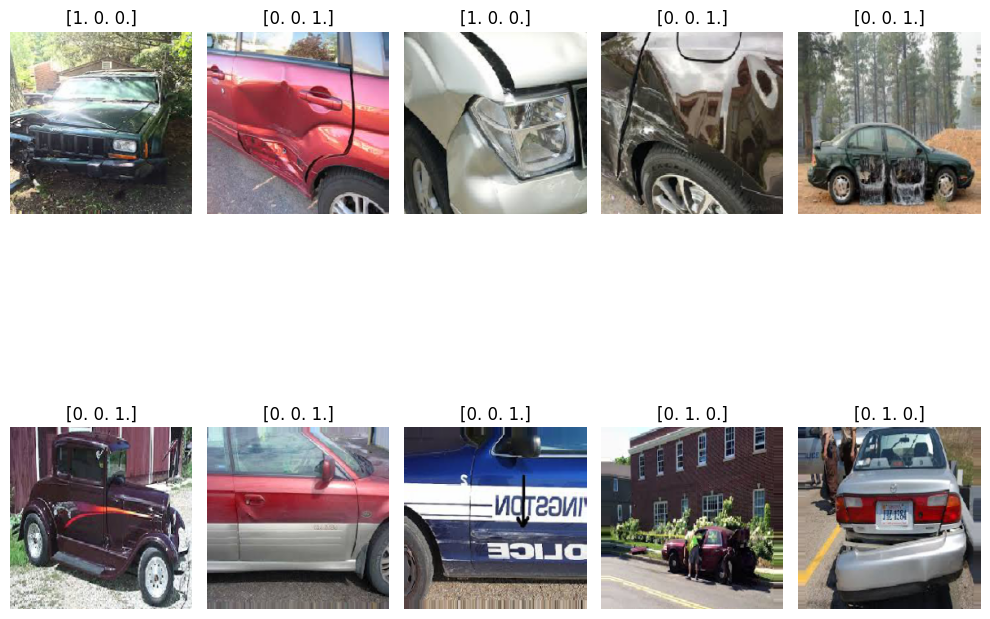

In [ ]:
plot_images(body_train_set)

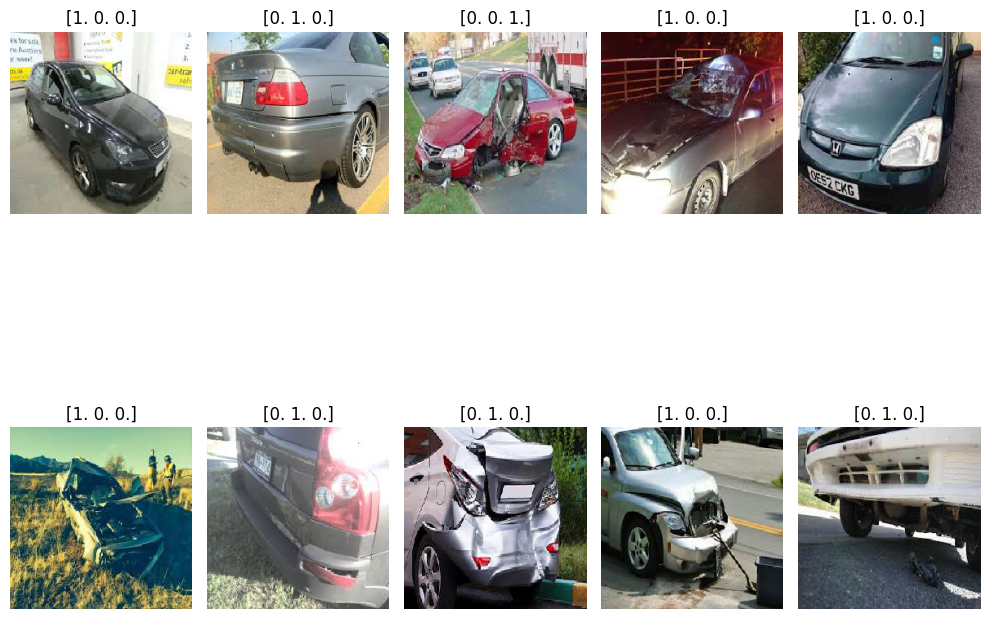

In [ ]:
plot_images(body_val_set)

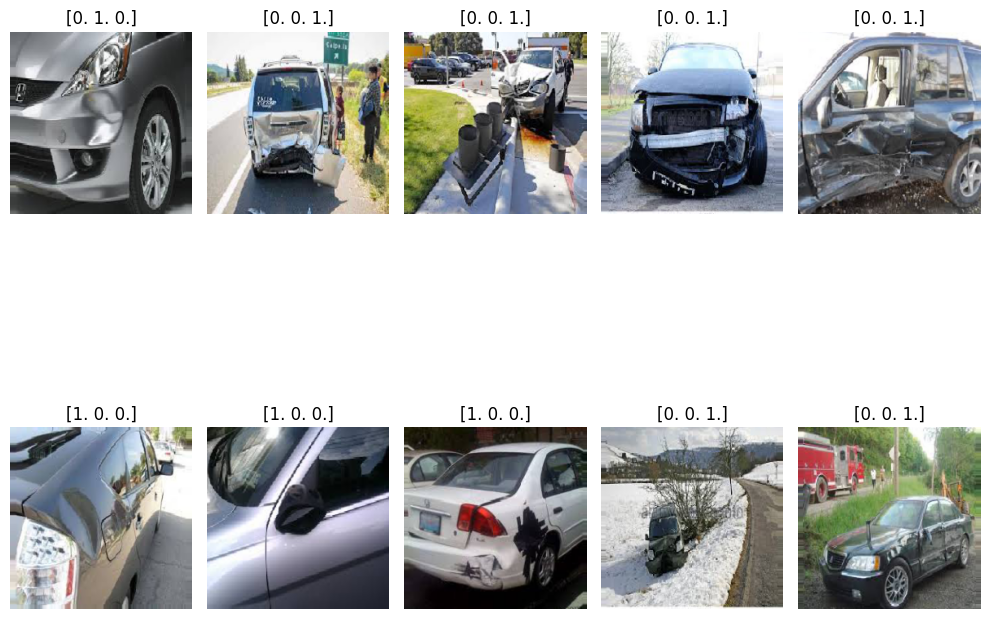

In [ ]:
plot_images(level_train_set)

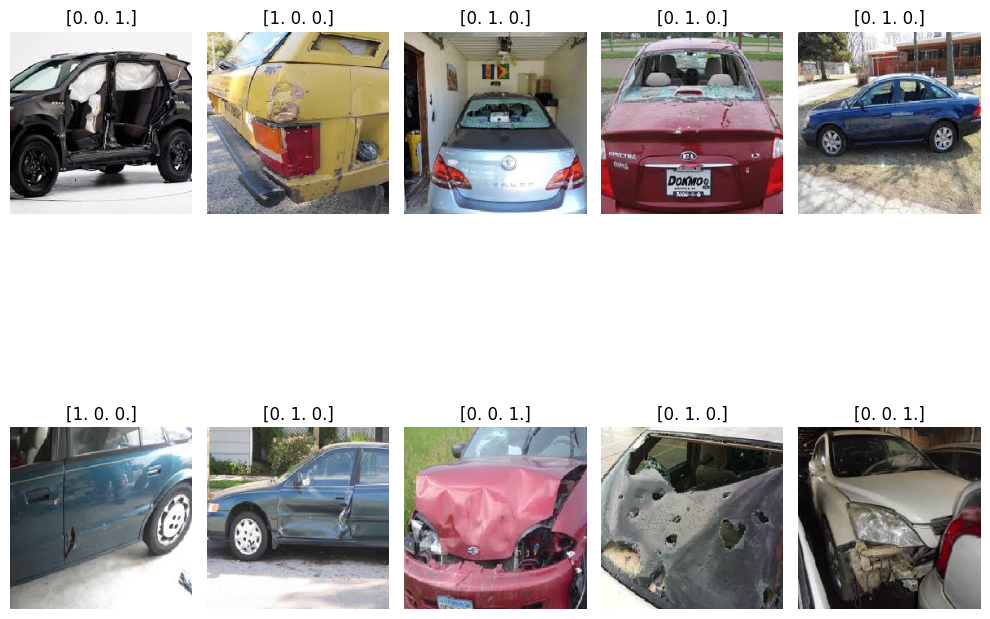

In [ ]:
plot_images(level_val_set)

Model Building

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
vgg = VGG16(input_shape = imagesize + [3], weights = 'imagenet', include_top = False)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output)
pred = Dense(3, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = pred)
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy','AUC'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

*For Body*

In [ ]:
hist1 = model.fit_generator(
    body_train_set,
    validation_data = body_val_set,
    epochs = 30,
    steps_per_epoch = len(body_train_set)/32,
    validation_steps = len(body_val_set)/32
)
hist1

TypeError: ignored

In [ ]:
res1 = model.evaluate(body_train_set)
res1

99/99 [==============================] - 27s 277ms/step - loss: 0.3436 - accuracy: 0.8726 - auc: 0.9677


[0.3436161279678345, 0.8725985884666443, 0.9676913619041443]

In [ ]:
res2 = model.evaluate(body_val_set)
res2

18/18 [==============================] - 2s 86ms/step - loss: 1.0005 - accuracy: 0.6491 - auc: 0.8235


[1.00050950050354, 0.6491228342056274, 0.8235012292861938]

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/Dataset/Model/body.h5")

In [ ]:
from skimage.transform import resize
body_model = load_model('/content/drive/MyDrive/Dataset/Model/body.h5')

def body_detect(frame):
  img = cv2.resize(frame,(224,224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if(np.max(img)>1):
    img = img/255.0
  img = np.array([img])
  pred = body_model.predict(img)
  label = ["front", "rear", "side"]
  preds = label[np.argmax(pred)]
  return preds

In [ ]:
data = '/content/0010.JPEG'
image = cv2.imread(data)
print(body_detect(image))

1/1 [==============================] - 0s 147ms/step
rear


In [ ]:
data2 = '/content/drive/MyDrive/Dataset/body/validation/02-side/0004.JPEG'
image2 = cv2.imread(data2)
print(body_detect(image2))

1/1 [==============================] - 0s 164ms/step
side


For level

In [ ]:
hist2 = model.fit_generator(
    level_train_set,
    validation_data = level_val_set,
    epochs = 30,
    steps_per_epoch = len(level_train_set)//10,
    validation_steps = len(level_val_set)//10
)
hist2

Epoch 1/30
9/9 [==============================] - 38s 4s/step - loss: 3.2355 - accuracy: 0.2778 - auc: 0.4454 - val_loss: 1.8588 - val_accuracy: 0.6000 - val_auc: 0.7175
Epoch 2/30
9/9 [==============================] - 37s 4s/step - loss: 2.6738 - accuracy: 0.3889 - auc: 0.5782 - val_loss: 3.3611 - val_accuracy: 0.4000 - val_auc: 0.5400
Epoch 3/30
9/9 [==============================] - 33s 4s/step - loss: 2.3022 - accuracy: 0.4000 - auc: 0.6245 - val_loss: 1.1019 - val_accuracy: 0.4000 - val_auc: 0.7050
Epoch 4/30
9/9 [==============================] - 30s 3s/step - loss: 2.0070 - accuracy: 0.4778 - auc: 0.6671 - val_loss: 0.2721 - val_accuracy: 0.9000 - val_auc: 0.9750
Epoch 5/30
9/9 [==============================] - 25s 3s/step - loss: 1.7270 - accuracy: 0.4889 - auc: 0.7214 - val_loss: 3.8067 - val_accuracy: 0.3000 - val_auc: 0.4900
Epoch 6/30
9/9 [==============================] - 21s 2s/step - loss: 1.1528 - accuracy: 0.6556 - auc: 0.8238 - val_loss: 0.5030 - val_accuracy: 0.900

In [ ]:
res3 = model.evaluate(level_train_set)
res3

98/98 [==============================] - 37s 381ms/step - loss: 0.5069 - accuracy: 0.8212 - auc: 0.9440


[0.5068619847297668, 0.8212461471557617, 0.9439736604690552]

In [ ]:
res4 = model.evaluate(level_val_set)
res4

18/18 [==============================] - 2s 138ms/step - loss: 1.0981 - accuracy: 0.6082 - auc: 0.8247


[1.0981388092041016, 0.6081871390342712, 0.8246895670890808]

In [ ]:
from tensorflow.keras.models import load_model
model.save("/content/drive/MyDrive/Dataset/Model/level.h5")

In [ ]:
from skimage.transform import resize
level_model = load_model('/content/drive/MyDrive/Dataset/Model/level.h5')

In [ ]:
def level_detect(frame):
  img = cv2.resize(frame,(224,224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if(np.max(img)>1):
    img = img/255.0
  img = np.array([img])
  pred = level_model.predict(img)
  label = ["minor", "moderate", "severe"]
  preds = label[np.argmax(pred)]
  return preds

In [ ]:
data3 = '/content/drive/MyDrive/Dataset/level/validation/02-moderate/0007.JPEG'
image3 = cv2.imread(data3)
print(level_detect(image3))

1/1 [==============================] - 0s 158ms/step
moderate
